## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import re
from community import community_louvain

In [2]:
#importing english language module for spacy

!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


We shall be using Spacy's 'en_core_web_sm' model for our entity recognition for all the entities present in the five Percy Jackson books.

In [3]:
#Named Entity Recognition Model

NER = spacy.load('en_core_web_sm')

## Functions

In [4]:
#function to create a document to store the output of the NER model

def create_book_doc(all_books, i):
    
    book = all_books[i]
    book_text = open(book, encoding="mbcs").read()
    book_doc = NER(book_text)
    return book_doc

In [5]:
#function to filter named entities from entity_list

def filter_entity(entity_list, character_df):
    return [entity for entity in entity_list
            if entity in list(character_df.character)
            or entity in list(character_df.character_firstname)]
            

In [6]:
#function to create entity_list and return a dataframe of entity_list for each sentence in a book

def create_sentence_entity_df(book_doc): 
    
    #create a df with the sentences and entities per sentence in a book
    sentence_entity_df = []

    for sentence in book_doc.sents:
        entity_list = [entity.text for entity in sentence.ents]
        sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})
        
    sentence_entity_df = pd.DataFrame(sentence_entity_df)

    
    #filter out only the named entities from entity_list
    sentence_entity_df['character_entities'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
        
    #filter out empty entities
    sentence_entity_df = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
    
    #convert a fullname to firstname only
    sentence_entity_df['character_entities'] = sentence_entity_df['character_entities'].apply(
                                                    lambda x: [item.split()[0] for item in x])
    
    return sentence_entity_df

In [7]:
#function to create relationships between entities 

def create_relationship_df(sentence_entity_df_filtered):

    window_size = 5
    character_list = []
    relationships = []

    for i in range(0, sentence_entity_df_filtered.index[-1]):
        end_i = min(i + 5, sentence_entity_df_filtered.index[-1])
        character_list = sum((sentence_entity_df_filtered.loc[i: end_i].character_entities), [])

        character_list_unique = [character_list[i] for i in range(len(character_list))
                                 if(i==0) or character_list[i] != character_list[i-1]]

        #now let us create the source and target of the relationships

        if len(character_list_unique) > 1:
            for idx, a in enumerate(character_list_unique[:-1]):
                b = character_list_unique[idx + 1]
                relationships.append({'source': a, 'target': b})
               
    relationship_df = pd.DataFrame(relationships)
    
    return relationship_df

In [8]:
#function to create an edgelist dataframe

def create_edgelist(relationship_df):
    
    #change reversed relations i.e. b->a to a->b
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), 
                                          columns = relationship_df.columns)
    
    #adding edge weights
    relationship_df['value'] = 1
    relationship_df = relationship_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
    
    return relationship_df

In [9]:
#function to create a graph visualization

def create_community_graph(relationship_df, i):
    
    G = nx.from_pandas_edgelist(relationship_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using = nx.Graph())
    
    #store degree of each node as an attribute for size
    node_degree = dict(G.degree)
    nx.set_node_attributes(G, node_degree, 'size')
    
    #create communities
    communities = community_louvain.best_partition(G, random_state=99)
    nx.set_node_attributes(G, communities, 'group')
    
    #display and save the graph visualization
    community_network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
    community_network.from_nx(G)
    community_network.save_graph(f'Graphs/Community_relationships_{i}.html')
#     community_network.show(f'Community_relationships_{i}.html')
    
    return community_network, G
    

## Reading the books

We need to read through each of the books and store data about the entities in each sentence of the book. For now, let us work with the first book, i.e. Book 1 The Lightning Thief.

In [10]:
all_books = [b for b in os.scandir('Books') if '.txt' in b.name]

In [11]:
all_books

[<DirEntry 'Book 1 The Lightning Thief.txt'>,
 <DirEntry 'Book 2 Sea of Monsters.txt'>,
 <DirEntry "Book 3 The Titan's Curse.txt">,
 <DirEntry 'Book 4 The Battle of the Labyrinth.txt'>,
 <DirEntry 'Book 5 The Last Olympian.txt'>]

## Book 1

For the demonstration of the graph building and its visualization, let us only work with Book 1. 
Let us try out our NER model on it.

In [12]:
book_1 = all_books[0]
book_text_1 = open(book_1, encoding="mbcs").read()
book_doc_1 = NER(book_text_1)

Now let us visualize the entities that were identified.

In [13]:
displacy.render(book_doc_1[598:1500], style='ent', jupyter=True)

As we can see, the model labelled most of the entities accurately. The few mislabels are due to the text being alphanumeric (as this book was a teen novel and that was a pretty cool thing to do). Now let us load the characters we scraped from the wiki.

In [14]:
character_df = pd.read_csv('Books/characters.csv')
character_df

Unnamed: 0                                     book  \
0             0  Category:The Lightning Thief characters   
1             1  Category:The Lightning Thief characters   
2             2  Category:The Lightning Thief characters   
3             3  Category:The Lightning Thief characters   
4             4  Category:The Lightning Thief characters   
..          ...                                      ...   
432         432    Category:The Last Olympian characters   
433         433    Category:The Last Olympian characters   
434         434    Category:The Last Olympian characters   
435         435    Category:The Last Olympian characters   
436         436    Category:The Last Olympian characters   

                      character  
0                        Alecto  
1                Annabeth Chase  
2                          Ares  
3                         Argus  
4               Barbara Walters  
..                          ...  
432                      Triton  
433                      Typhon  
434                       Tyson  
435  William H. Seward's Statue  
436                        Zeus  

[437 rows x 3 columns]

Here we see that there is information included within parentheses for certain characters, and a few of them are referred to with their prefix of Mr/Mrs/Ms/Dr. The rest are written with both their full name, and their first name. Let us extract the first names of these characters.

In [15]:
#removing prefixes, brackets and extra text from the names

character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))

character_df['character_firstname'] = character_df['character'].apply(
                lambda x: x if x.startswith('Mr. ') 
                else (x if x.startswith('Mrs. ') 
                else (x if x.startswith('Ms. ') 
                else (x if x.startswith('Dr. ') 
                else x.split(' ', 1)[0] ) )) )




pd.set_option('display.max_rows', None)
character_df

Unnamed: 0                                             book  \
0             0          Category:The Lightning Thief characters   
1             1          Category:The Lightning Thief characters   
2             2          Category:The Lightning Thief characters   
3             3          Category:The Lightning Thief characters   
4             4          Category:The Lightning Thief characters   
5             5          Category:The Lightning Thief characters   
6             6          Category:The Lightning Thief characters   
7             7          Category:The Lightning Thief characters   
8             8          Category:The Lightning Thief characters   
9             9          Category:The Lightning Thief characters   
10           10          Category:The Lightning Thief characters   
11           11          Category:The Lightning Thief characters   
12           12          Category:The Lightning Thief characters   
13           13          Category:The Lightning Thief characters   
14           14          Category:The Lightning Thief characters   
15           15          Category:The Lightning Thief characters   
16           16          Category:The Lightning Thief characters   
17           17          Category:The Lightning Thief characters   
18           18          Category:The Lightning Thief characters   
19           19          Category:The Lightning Thief characters   
20           20          Category:The Lightning Thief characters   
21           21          Category:The Lightning Thief characters   
22           22          Category:The Lightning Thief characters   
23           23          Category:The Lightning Thief characters   
24           24          Category:The Lightning Thief characters   
25           25          Category:The Lightning Thief characters   
26           26          Category:The Lightning Thief characters   
27           27          Category:The Lightning Thief characters   
28           28          Category:The Lightning Thief characters   
29           29          Category:The Lightning Thief characters   
30           30          Category:The Lightning Thief characters   
31           31          Category:The Lightning Thief characters   
32           32          Category:The Lightning Thief characters   
33           33          Category:The Lightning Thief characters   
34           34          Category:The Lightning Thief characters   
35           35          Category:The Lightning Thief characters   
36           36          Category:The Lightning Thief characters   
37           37          Category:The Lightning Thief characters   
38           38          Category:The Lightning Thief characters   
39           39          Category:The Lightning Thief characters   
40           40          Category:The Lightning Thief characters   
41           41          Category:The Lightning Thief characters   
42           42          Category:The Lightning Thief characters   
43           43          Category:The Lightning Thief characters   
44           44          Category:The Lightning Thief characters   
45           45          Category:The Lightning Thief characters   
46           46          Category:The Lightning Thief characters   
47           47          Category:The Lightning Thief characters   
48           48          Category:The Lightning Thief characters   
49           49          Category:The Lightning Thief characters   
50           50          Category:The Lightning Thief characters   
51           51          Category:The Lightning Thief characters   
52           52          Category:The Lightning Thief characters   
53           53          Category:The Lightning Thief characters   
54           54          Category:The Lightning Thief characters   
55           55          Category:The Lightning Thief characters   
56           56          Category:The Lightning Thief characters   
57           57          Category:The Lightning Thief charact

We have succesfully gotten the names of the characters the way they have been mentioned in the books.

## Entitiy list per sentence in the books

Now let us create a list of all the entities per sentence present in the books. Spacy has recognized all the entities, and we shall collate the entities that are useful to us, i.e. the names. We shall again just work with Book 1.

In [16]:
sentence_entity_df = []

for sentence in book_doc_1.sents:
    entity_list = [entity.text for entity in sentence.ents]
    sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})

In [17]:
sentence_entity_df_book_1 = pd.DataFrame(sentence_entity_df)
sentence_entity_df_book_1

sentence  \
0     (\n\n, Copyright, Â, ©, 2005, by, Rick, Riorda...   
1     (No, part, of, this, book, may, be, reproduced...   
2     (For, information, address, Hyperion, Books, f...   
3     (\n\n, First, Edition, \n, 579, 10, 8, 6, \n\n...   
4     (\n\n, ISBN, 0, -, 7868, -, 5629, -, 7, (, har...   
5           (I, Play, Pinochle, with, a, Horse, 57, \n)   
6     (6-, I, Become, Supreme, Lord, of, the, Bathro...   
7     (My, Dinner, Goes, Up, in, Smoke, 93, \n, 8, â...   
8     (\n\n\n, Look, ,, I, did, n't, want, to, be, a...   
9     (\n\n, If, you, 're, reading, this, because, y...   
10    (Believe, what-, \n, ever, lie, your, mom, or,...   
11    (\n\n, Being, a, half, -, blood, is, dangerous...   
12                                   (It, 's, scary, .)   
13    (Most, of, the, \n, time, ,, it, gets, you, ki...   
14    (\n\n, If, you, 're, a, normal, kid, ,, readin...   
15                                        (Read, on, .)   
16    (I, envy, you, for, being, able, to, \n, belie...   
17    (\n\n, But, if, you, recognize, yourself, in, ...   
18                 (You, \n, might, be, one, of, us, .)   
19    (And, once, you, know, that, ,, it, 's, only, ...   
20      (\n\n, Do, n't, say, I, did, n't, warn, you, .)   
21              (\n\n, My, name, is, Percy, Jackson, .)   
22                 (\n\n, I, 'm, twelve, years, old, .)   
23    (Until, a, few, months, ago, ,, I, was, a, \n,...   
24                   (\n\n, Am, I, a, troubled, kid, ?)   
25                                               (\n\n)   
26                                            (Yeah, .)   
27                           (You, could, say, that, .)   
28    (\n\n\n, [, 1, ], \n\n\n\n, I, could, start, a...   
29    (\n\n, I, know, â€, ”, it, sounds, like, tortu...   
30             (Most, Yancy, field, trips, \n, were, .)   
31    (\n\n, But, Mr., Brunner, ,, our, Latin, teach...   
32    (\n\n, Mr., Brunner, was, this, middle, -, age...   
33    (He, had, thinning, hair, and, a, scruffy, bea...   
34    (You, \n, would, n't, think, he, 'd, be, cool,...   
35    (He, also, had, this, awesome, \n, collection,...   
36      (\n\n, I, hoped, the, trip, would, be, okay, .)   
37    (At, least, ,, I, hoped, that, \n, for, once, ...   
38                     (\n\n, Boy, ,, was, I, wrong, .)   
39    (\n\n, See, ,, bad, things, happen, to, me, on...   
40    (Like, at, my, \n, fifth, -, grade, school, ,,...   
41    (I, \n, was, n't, aiming, for, the, school, bu...   
42    (And, before, that, ,, at, my, fourth, -, grad...   
43          (And, the, \n, time, before, that, ., ., .)   
44                    (Well, ,, you, get, the, idea, .)   
45    (\n\n\n, [, 21, \n\n\n\n, This, trip, ,, I, wa...   
46    (\n\n, All, the, way, into, the, city, ,, I, p...   
47             (\n\n, Grover, was, an, easy, target, .)   
48                                (He, was, scrawny, .)   
49        (He, cried, \n, when, he, got, frustrated, .)   
50    (He, must, 've, been, held, back, several, \n,...   
51    (On, top, of, all, that, ,, \n, he, was, cripp...   
52    (He, had, a, note, excusing, him, from, PE, fo...   
53    (He, walked, funny, ,, like, every, step, hurt...   
54    (You, should, 've, seen, him, run, \n, when, i...   
55    (\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...   
56    (\n, The, headmaster, had, threatened, me, wit...   
57    (\n\n, ", I, 'm, going, to, kill, her, ,, ", I...   
58         (\n\n, Grover, tried, to, calm, me, down, .)   
59                                 (", It, 's, okay, .)   
60                  (I, like, peanut, \n, butter, ., ")   
61    (\n\n, He, dodged, another, piece, of, Nancy, ...   
62                        (\n\n, ", That, 's, it, ., ")   
63    (I, started, to, get, up, ,, but, Grover, pull...   
64    (\n\n, ", You, 're, already, on, probation, ,,...   
65    (", You, \n, know, who, 'll, get, blamed, if, ...   
66    (\n\n, Looking, back, on, it, ,, I, wish, I, '...   
67    (In, -, school, suspension, w

The dataframe above shows all the sentences and the entities present in them from Book 1. We are only interested with entities that are characters. Let us filter this dataframe.

In [18]:
sentence_entity_df_book_1['character_entities'] = sentence_entity_df_book_1['entities'].apply(
                                                        lambda x: filter_entity(x, character_df))
    
sentence_entity_df_book_1

sentence  \
0     (\n\n, Copyright, Â, ©, 2005, by, Rick, Riorda...   
1     (No, part, of, this, book, may, be, reproduced...   
2     (For, information, address, Hyperion, Books, f...   
3     (\n\n, First, Edition, \n, 579, 10, 8, 6, \n\n...   
4     (\n\n, ISBN, 0, -, 7868, -, 5629, -, 7, (, har...   
5           (I, Play, Pinochle, with, a, Horse, 57, \n)   
6     (6-, I, Become, Supreme, Lord, of, the, Bathro...   
7     (My, Dinner, Goes, Up, in, Smoke, 93, \n, 8, â...   
8     (\n\n\n, Look, ,, I, did, n't, want, to, be, a...   
9     (\n\n, If, you, 're, reading, this, because, y...   
10    (Believe, what-, \n, ever, lie, your, mom, or,...   
11    (\n\n, Being, a, half, -, blood, is, dangerous...   
12                                   (It, 's, scary, .)   
13    (Most, of, the, \n, time, ,, it, gets, you, ki...   
14    (\n\n, If, you, 're, a, normal, kid, ,, readin...   
15                                        (Read, on, .)   
16    (I, envy, you, for, being, able, to, \n, belie...   
17    (\n\n, But, if, you, recognize, yourself, in, ...   
18                 (You, \n, might, be, one, of, us, .)   
19    (And, once, you, know, that, ,, it, 's, only, ...   
20      (\n\n, Do, n't, say, I, did, n't, warn, you, .)   
21              (\n\n, My, name, is, Percy, Jackson, .)   
22                 (\n\n, I, 'm, twelve, years, old, .)   
23    (Until, a, few, months, ago, ,, I, was, a, \n,...   
24                   (\n\n, Am, I, a, troubled, kid, ?)   
25                                               (\n\n)   
26                                            (Yeah, .)   
27                           (You, could, say, that, .)   
28    (\n\n\n, [, 1, ], \n\n\n\n, I, could, start, a...   
29    (\n\n, I, know, â€, ”, it, sounds, like, tortu...   
30             (Most, Yancy, field, trips, \n, were, .)   
31    (\n\n, But, Mr., Brunner, ,, our, Latin, teach...   
32    (\n\n, Mr., Brunner, was, this, middle, -, age...   
33    (He, had, thinning, hair, and, a, scruffy, bea...   
34    (You, \n, would, n't, think, he, 'd, be, cool,...   
35    (He, also, had, this, awesome, \n, collection,...   
36      (\n\n, I, hoped, the, trip, would, be, okay, .)   
37    (At, least, ,, I, hoped, that, \n, for, once, ...   
38                     (\n\n, Boy, ,, was, I, wrong, .)   
39    (\n\n, See, ,, bad, things, happen, to, me, on...   
40    (Like, at, my, \n, fifth, -, grade, school, ,,...   
41    (I, \n, was, n't, aiming, for, the, school, bu...   
42    (And, before, that, ,, at, my, fourth, -, grad...   
43          (And, the, \n, time, before, that, ., ., .)   
44                    (Well, ,, you, get, the, idea, .)   
45    (\n\n\n, [, 21, \n\n\n\n, This, trip, ,, I, wa...   
46    (\n\n, All, the, way, into, the, city, ,, I, p...   
47             (\n\n, Grover, was, an, easy, target, .)   
48                                (He, was, scrawny, .)   
49        (He, cried, \n, when, he, got, frustrated, .)   
50    (He, must, 've, been, held, back, several, \n,...   
51    (On, top, of, all, that, ,, \n, he, was, cripp...   
52    (He, had, a, note, excusing, him, from, PE, fo...   
53    (He, walked, funny, ,, like, every, step, hurt...   
54    (You, should, 've, seen, him, run, \n, when, i...   
55    (\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...   
56    (\n, The, headmaster, had, threatened, me, wit...   
57    (\n\n, ", I, 'm, going, to, kill, her, ,, ", I...   
58         (\n\n, Grover, tried, to, calm, me, down, .)   
59                                 (", It, 's, okay, .)   
60                  (I, like, peanut, \n, butter, ., ")   
61    (\n\n, He, dodged, another, piece, of, Nancy, ...   
62                        (\n\n, ", That, 's, it, ., ")   
63    (I, started, to, get, up, ,, but, Grover, pull...   
64    (\n\n, ", You, 're, already, on, probation, ,,...   
65    (", You, \n, know, who, 'll, get, blamed, if, ...   
66    (\n\n, Looking, back, on, it, ,, I, wish, I, '...   
67    (In, -, school, suspension, w

There are multiple character_entities that are empty. Let us filter them out. 

In [19]:
sentence_entity_df_filtered_book_1 = sentence_entity_df_book_1[sentence_entity_df_book_1['character_entities'].map(len) > 0]
sentence_entity_df_filtered_book_1

sentence  \
21              (\n\n, My, name, is, Percy, Jackson, .)   
46    (\n\n, All, the, way, into, the, city, ,, I, p...   
55    (\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...   
61    (\n\n, He, dodged, another, piece, of, Nancy, ...   
66    (\n\n, Looking, back, on, it, ,, I, wish, I, '...   
77    (\n\n, From, her, first, day, ,, Mrs., Dodds, ...   
98      (\n\n, ", Titan, ,, ", I, corrected, myself, .)   
101   (\n, But, his, wife, hid, baby, Zeus, ,, and, ...   
102            (And, later, ,, when, Zeus, grew, up, .)   
106   (\n\n, Behind, me, ,, Nancy, Bobofit, mumbled,...   
110   (\n\n, ", Shut, up, ,, ", Nancy, hissed, ,, he...   
111    (\n\n, At, least, Nancy, got, packed, ,, too, .)   
119   (Zeus, did, indeed, feed, Kronos, a, mixture, ...   
139                              (Percy, Jackson, ., ")   
155   (Nancy, Bobofit, \n, was, trying, to, pickpock...   
177   (\n\n, I, was, about, to, unwrap, my, sandwich...   
185   (\n\n, I, do, n't, remember, touching, her, ,,...   
189   (\n\n, As, soon, as, Mrs., Dodds, was, sure, p...   
225   (She, 's, going, to, make, me, buy, a, new, sh...   
246   (\n\n, ", We, are, not, fools, ,, Percy, Jacks...   
265                 (\n\n, ", What, ho, ,, Percy, !, ")   
292   (Nancy, Bobofit, was, still, standing, there, ...   
299   (I, asked, \n, Nancy, what, she, was, talking,...   
320   (\n, ", Percy, ,, there, is, no, Mrs., Dodds, ...   
343   (I, got, into, more, fights, \n, with, Nancy, ...   
356   (Grover, ,, who, 'd, \n\n\n, [, 17, ], \n\n\n\...   
364   (There, was, no, way, I, was, going, to, remem...   
382           (worried, about, \n, Percy, ,, sir, ., ")   
402   (Now, let, 's, just, worry, \n, about, keeping...   
437                 (\n\n, ", Percy, ,, ", he, said, .)   
443   (Nancy, Bobofit, smirked, at, me, and, \n, mad...   
456                (you, 're, not, normal, ,, Percy, .)   
515   (\n\n, ", Grover, ,, ", I, said, ,, ", what, e...   
534                             (\n\n, ", Grover, ?, ")   
541                  (\n\n, ", Not, funny, ,, Percy, .)   
565   (\n\n, ", Grover, ?, ", \n\n, ", Yeah, ?, ", \...   
567   (", Percy, ,, \n, what, did, you, see, back, a...   
625   (\n\n, Finally, ,, she, married, Gabe, Ugliano...   
662                      (Am, I, right, ,, Eddie, ?, ")   
678   (During, school, months, ,, it, was, Gabe, 's,...   
688                                    (", Percy, ?, ")   
709   (\n\n, From, the, other, room, ,, Gabe, yelled...   
712   (She, should, 've, \n, been, married, to, a, m...   
725   (Even, \n, Nancy, Bobofit, suddenly, did, n't,...   
745   (My, mom, and, I, had, n't, been, to, \n, Mont...   
746   (\n\n, Gabe, appeared, in, the, doorway, and, ...   
748   (\n\n, I, wanted, to, punch, him, ,, but, I, m...   
751   (\n\n, ", I, was, on, my, way, ,, honey, ,, ",...   
789   (\n\n, ", Thank, you, ,, Percy, ,, ", my, mom,...   
794   (She, ruffled, my, hair, and, went, to, make, ...   
802      (But, that, did, n't, \n, matter, to, Gabe, .)   
805   (As, Gabe, \n, reached, the, doorway, ,, I, ma...   
822   (\n\n, See, ,, Gabe, had, once, told, my, mom,...   
828   (This, â€, ”, along, \n, with, keeping, her, m...   
837   (\n\n, ", He, was, kind, ,, Percy, ,, ", she, ...   
852   (", He, was, only, with, me, for, one, \n, sum...   
888   (\n\n, ", You, say, that, as, if, it, 's, a, b...   
917   (\n\n, ", I, 'm, sorry, ,, Percy, ,, ", she, s...   
954   (\n\n, ", Percy, ,, ", she, said, ,, shouting,...   
1015  (\n\n, ", Were, those, old, ladies, at, the, f...   
1033                            (\n\n, ", Grover, !, ")   
1102                                  (", Grover, !, ")   
1107  (\n\n, ", Percy, ,, ", my, mother, said, ,, ",...   
1158    (\n\n, ", We, do, n't, have, time, ,, Percy, .)   
1171  (\n\n, Together, ,, we, draped, Grover, 's, ar...   
1203  (\n\n, Not, a, scratch, ,, I, remembered, Gabe...   
1205           (\n\n, ", Percy, ,, ", my, mom, said, .)   
1222                               

We can see that we have two seperate entities for characters due to the fact that they are referred to with their full name as well as their first name ('Percy Jackson' and 'Percy' are two seperate entities). Let us take the first name of all the entities to keep the entities consistent.

In [20]:
sentence_entity_df_filtered_book_1['character_entities'] = sentence_entity_df_filtered_book_1['character_entities'].apply(
                                                    lambda x: [item.split()[0] for item in x])

sentence_entity_df_filtered_book_1

C:\Users\varun\AppData\Local\Temp\ipykernel_13688\2519888507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df_filtered_book_1['character_entities'] = sentence_entity_df_filtered_book_1['character_entities'].apply(


sentence  \
21              (\n\n, My, name, is, Percy, Jackson, .)   
46    (\n\n, All, the, way, into, the, city, ,, I, p...   
55    (\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...   
61    (\n\n, He, dodged, another, piece, of, Nancy, ...   
66    (\n\n, Looking, back, on, it, ,, I, wish, I, '...   
77    (\n\n, From, her, first, day, ,, Mrs., Dodds, ...   
98      (\n\n, ", Titan, ,, ", I, corrected, myself, .)   
101   (\n, But, his, wife, hid, baby, Zeus, ,, and, ...   
102            (And, later, ,, when, Zeus, grew, up, .)   
106   (\n\n, Behind, me, ,, Nancy, Bobofit, mumbled,...   
110   (\n\n, ", Shut, up, ,, ", Nancy, hissed, ,, he...   
111    (\n\n, At, least, Nancy, got, packed, ,, too, .)   
119   (Zeus, did, indeed, feed, Kronos, a, mixture, ...   
139                              (Percy, Jackson, ., ")   
155   (Nancy, Bobofit, \n, was, trying, to, pickpock...   
177   (\n\n, I, was, about, to, unwrap, my, sandwich...   
185   (\n\n, I, do, n't, remember, touching, her, ,,...   
189   (\n\n, As, soon, as, Mrs., Dodds, was, sure, p...   
225   (She, 's, going, to, make, me, buy, a, new, sh...   
246   (\n\n, ", We, are, not, fools, ,, Percy, Jacks...   
265                 (\n\n, ", What, ho, ,, Percy, !, ")   
292   (Nancy, Bobofit, was, still, standing, there, ...   
299   (I, asked, \n, Nancy, what, she, was, talking,...   
320   (\n, ", Percy, ,, there, is, no, Mrs., Dodds, ...   
343   (I, got, into, more, fights, \n, with, Nancy, ...   
356   (Grover, ,, who, 'd, \n\n\n, [, 17, ], \n\n\n\...   
364   (There, was, no, way, I, was, going, to, remem...   
382           (worried, about, \n, Percy, ,, sir, ., ")   
402   (Now, let, 's, just, worry, \n, about, keeping...   
437                 (\n\n, ", Percy, ,, ", he, said, .)   
443   (Nancy, Bobofit, smirked, at, me, and, \n, mad...   
456                (you, 're, not, normal, ,, Percy, .)   
515   (\n\n, ", Grover, ,, ", I, said, ,, ", what, e...   
534                             (\n\n, ", Grover, ?, ")   
541                  (\n\n, ", Not, funny, ,, Percy, .)   
565   (\n\n, ", Grover, ?, ", \n\n, ", Yeah, ?, ", \...   
567   (", Percy, ,, \n, what, did, you, see, back, a...   
625   (\n\n, Finally, ,, she, married, Gabe, Ugliano...   
662                      (Am, I, right, ,, Eddie, ?, ")   
678   (During, school, months, ,, it, was, Gabe, 's,...   
688                                    (", Percy, ?, ")   
709   (\n\n, From, the, other, room, ,, Gabe, yelled...   
712   (She, should, 've, \n, been, married, to, a, m...   
725   (Even, \n, Nancy, Bobofit, suddenly, did, n't,...   
745   (My, mom, and, I, had, n't, been, to, \n, Mont...   
746   (\n\n, Gabe, appeared, in, the, doorway, and, ...   
748   (\n\n, I, wanted, to, punch, him, ,, but, I, m...   
751   (\n\n, ", I, was, on, my, way, ,, honey, ,, ",...   
789   (\n\n, ", Thank, you, ,, Percy, ,, ", my, mom,...   
794   (She, ruffled, my, hair, and, went, to, make, ...   
802      (But, that, did, n't, \n, matter, to, Gabe, .)   
805   (As, Gabe, \n, reached, the, doorway, ,, I, ma...   
822   (\n\n, See, ,, Gabe, had, once, told, my, mom,...   
828   (This, â€, ”, along, \n, with, keeping, her, m...   
837   (\n\n, ", He, was, kind, ,, Percy, ,, ", she, ...   
852   (", He, was, only, with, me, for, one, \n, sum...   
888   (\n\n, ", You, say, that, as, if, it, 's, a, b...   
917   (\n\n, ", I, 'm, sorry, ,, Percy, ,, ", she, s...   
954   (\n\n, ", Percy, ,, ", she, said, ,, shouting,...   
1015  (\n\n, ", Were, those, old, ladies, at, the, f...   
1033                            (\n\n, ", Grover, !, ")   
1102                                  (", Grover, !, ")   
1107  (\n\n, ", Percy, ,, ", my, mother, said, ,, ",...   
1158    (\n\n, ", We, do, n't, have, time, ,, Percy, .)   
1171  (\n\n, Together, ,, we, draped, Grover, 's, ar...   
1203  (\n\n, Not, a, scratch, ,, I, remembered, Gabe...   
1205           (\n\n, ", Percy, ,, ", my, mom, said, .)   
1222                               

In [21]:
sentence_entity_df_book_1 = sentence_entity_df_filtered_book_1

## Creating relationships between the characters

Now that we have a list of all the characters in the first book, let us see all the characters that appear within a window of a number of sentences. The characters that appear in this window will tend to have a relationship with one another.

In [22]:
window_size = 5
character_list = []
relationships = []
for i in range(0, sentence_entity_df_book_1.index[-1]):
    end_i = min(i + window_size, sentence_entity_df_book_1.index[-1])
    character_list = sum((sentence_entity_df_book_1.loc[i: end_i].character_entities), [])
    
#     if i > 1000 and i < 2000:    #we see that there are entity lists that have two of the same entity in the list. 
#         print(character_list)    #We aren't interested in entity relationships with oneself so let us remove them


    character_list_unique = [character_list[i] for i in range(len(character_list))
                             if(i==0) or character_list[i] != character_list[i-1]]
    
    #now let us create the source and target of the relationships
    
    if len(character_list_unique) > 1:
        for idx, a in enumerate(character_list_unique[:-1]):
            b = character_list_unique[idx + 1]
            relationships.append({'source': a, 'target': b})

In [23]:
relationship_df_book_1 = pd.DataFrame(relationships)
relationship_df_book_1

source      target
0          Titan        Zeus
1          Titan        Zeus
2          Titan        Zeus
3           Zeus       Nancy
4           Zeus       Nancy
5           Zeus       Titan
6           Zeus       Titan
7           Zeus       Titan
8           Zeus       Titan
9           Zeus       Titan
10          Zeus       Titan
11         Nancy      Grover
12         Nancy      Grover
13         Nancy      Grover
14         Nancy      Grover
15         Nancy      Grover
16         Nancy      Grover
17         Nancy       Percy
18         Nancy       Percy
19         Nancy       Percy
20         Nancy       Percy
21         Nancy       Percy
22         Percy       Nancy
23         Nancy       Percy
24         Percy       Nancy
25        Chiron      Charon
26        Chiron      Charon
27        Chiron      Charon
28        Chiron      Charon
29        Chiron      Charon
30        Chiron      Charon
31        Grover       Percy
32        Grover       Percy
33        Grover       Percy
34        Grover       Percy
35          Gabe       Sally
36          Gabe       Sally
37          Gabe       Sally
38          Gabe       Sally
39         Sally        Gabe
40          Gabe       Sally
41         Sally        Gabe
42          Gabe       Sally
43         Sally        Gabe
44          Gabe       Sally
45          Gabe       Sally
46          Gabe       Sally
47         Sally        Gabe
48          Gabe       Sally
49         Sally        Gabe
50          Gabe       Sally
51         Sally        Gabe
52         Sally        Gabe
53         Percy        Gabe
54        Grover       Percy
55          Gabe       Percy
56          Gabe       Percy
57          Gabe       Percy
58          Gabe       Percy
59        Chiron    Minotaur
60        Chiron    Minotaur
61        Chiron    Minotaur
62          Gabe    Annabeth
63          Gabe    Annabeth
64      Annabeth      Chiron
65      Annabeth      Chiron
66      Annabeth      Chiron
67      Annabeth      Chiron
68         Percy      Chiron
69         Percy      Chiron
70         Percy      Chiron
71         Percy      Chiron
72         Percy      Chiron
73         Percy      Chiron
74        Chiron       Percy
75        Chiron       Percy
76        Chiron       Percy
77        Chiron       Percy
78        Chiron    Minotaur
79        Chiron    Minotaur
80        Chiron    Minotaur
81        Chiron       Percy
82         Percy      Chiron
83         Percy      Chiron
84         Percy      Chiron
85         Percy      Chiron
86         Percy      Chiron
87         Percy      Chiron
88        Chiron        Zeus
89        Chiron        Zeus
90        Chiron        Zeus
91         Percy      Chiron
92         Percy      Chiron
93         Percy   Olympians
94         Percy   Olympians
95         Percy   Olympians
96     Olympians      Chiron
97         Percy      Chiron
98         Percy      Chiron
99         Percy      Chiron
100        Percy      Chiron
101        Percy      Chiron
102        Percy      Chiron
103        Percy      Chiron
104        Percy      Chiron
105        Percy      Chiron
106       Chiron       Percy
107       Chiron       Percy
108       Chiron       Percy
109       Chiron       Percy
110       Chiron       Percy
111        Percy      Chiron
112        Percy      Chiron
113        Percy      Chiron
114         Zeus        Hera
115         Zeus        Hera
116         Zeus        Hera
117         Hera      Chiron
118         Zeus        Hera
119         Hera      Chiron
120         Zeus        Hera
121         Hera      Chiron
122         Zeus        Hera
123         Hera      Chiron
124    Olympians      Chiron
125       Chiron       Percy
126       Chiron       Percy
127       Chiron       Percy
128       Chiron       Percy
129        Nancy      Chiron
130        Nancy      Chiron
131        Nancy      Chiron
132        Nancy      Chiron
133       Chiron    Hercules
134       Chiron    Hercules
135       Chiron    Hercules
136       Chiron    Hercules
137     

We now have a dataframe of the relationships between the characters of Book 1. Here, we see that there are many "reversed relationships (like "Nancy" -> "Percy" and "Percy -> "Nancy"). Let us sort these relationships so that we can aggregate them easily. 

In [24]:
relationship_df_book_1 = pd.DataFrame(np.sort(relationship_df_book_1.values, axis=1), columns = relationship_df_book_1.columns)
relationship_df_book_1

source      target
0          Titan        Zeus
1          Titan        Zeus
2          Titan        Zeus
3          Nancy        Zeus
4          Nancy        Zeus
5          Titan        Zeus
6          Titan        Zeus
7          Titan        Zeus
8          Titan        Zeus
9          Titan        Zeus
10         Titan        Zeus
11        Grover       Nancy
12        Grover       Nancy
13        Grover       Nancy
14        Grover       Nancy
15        Grover       Nancy
16        Grover       Nancy
17         Nancy       Percy
18         Nancy       Percy
19         Nancy       Percy
20         Nancy       Percy
21         Nancy       Percy
22         Nancy       Percy
23         Nancy       Percy
24         Nancy       Percy
25        Charon      Chiron
26        Charon      Chiron
27        Charon      Chiron
28        Charon      Chiron
29        Charon      Chiron
30        Charon      Chiron
31        Grover       Percy
32        Grover       Percy
33        Grover       Percy
34        Grover       Percy
35          Gabe       Sally
36          Gabe       Sally
37          Gabe       Sally
38          Gabe       Sally
39          Gabe       Sally
40          Gabe       Sally
41          Gabe       Sally
42          Gabe       Sally
43          Gabe       Sally
44          Gabe       Sally
45          Gabe       Sally
46          Gabe       Sally
47          Gabe       Sally
48          Gabe       Sally
49          Gabe       Sally
50          Gabe       Sally
51          Gabe       Sally
52          Gabe       Sally
53          Gabe       Percy
54        Grover       Percy
55          Gabe       Percy
56          Gabe       Percy
57          Gabe       Percy
58          Gabe       Percy
59        Chiron    Minotaur
60        Chiron    Minotaur
61        Chiron    Minotaur
62      Annabeth        Gabe
63      Annabeth        Gabe
64      Annabeth      Chiron
65      Annabeth      Chiron
66      Annabeth      Chiron
67      Annabeth      Chiron
68        Chiron       Percy
69        Chiron       Percy
70        Chiron       Percy
71        Chiron       Percy
72        Chiron       Percy
73        Chiron       Percy
74        Chiron       Percy
75        Chiron       Percy
76        Chiron       Percy
77        Chiron       Percy
78        Chiron    Minotaur
79        Chiron    Minotaur
80        Chiron    Minotaur
81        Chiron       Percy
82        Chiron       Percy
83        Chiron       Percy
84        Chiron       Percy
85        Chiron       Percy
86        Chiron       Percy
87        Chiron       Percy
88        Chiron        Zeus
89        Chiron        Zeus
90        Chiron        Zeus
91        Chiron       Percy
92        Chiron       Percy
93     Olympians       Percy
94     Olympians       Percy
95     Olympians       Percy
96        Chiron   Olympians
97        Chiron       Percy
98        Chiron       Percy
99        Chiron       Percy
100       Chiron       Percy
101       Chiron       Percy
102       Chiron       Percy
103       Chiron       Percy
104       Chiron       Percy
105       Chiron       Percy
106       Chiron       Percy
107       Chiron       Percy
108       Chiron       Percy
109       Chiron       Percy
110       Chiron       Percy
111       Chiron       Percy
112       Chiron       Percy
113       Chiron       Percy
114         Hera        Zeus
115         Hera        Zeus
116         Hera        Zeus
117       Chiron        Hera
118         Hera        Zeus
119       Chiron        Hera
120         Hera        Zeus
121       Chiron        Hera
122         Hera        Zeus
123       Chiron        Hera
124       Chiron   Olympians
125       Chiron       Percy
126       Chiron       Percy
127       Chiron       Percy
128       Chiron       Percy
129       Chiron       Nancy
130       Chiron       Nancy
131       Chiron       Nancy
132       Chiron       Nancy
133       Chiron    Hercules
134       Chiron    Hercules
135       Chiron    Hercules
136       Chiron    Hercules
137     

Let us assume that each relation two entities have with each other is of a certain value (say 1). Hence the more the number of relations, the stronger the relationship is. Let us have this value as the weight of the relationship.

In [25]:
relationship_df_book_1['value'] = 1
relationship_df_book_1 = relationship_df_book_1.groupby(['source', 'target'], sort=False, as_index=False).sum()

relationship_df_book_1

source      target  value
0         Titan        Zeus     25
1         Nancy        Zeus      2
2        Grover       Nancy      6
3         Nancy       Percy      8
4        Charon      Chiron      6
5        Grover       Percy     18
6          Gabe       Sally     29
7          Gabe       Percy     16
8        Chiron    Minotaur     10
9      Annabeth        Gabe      2
10     Annabeth      Chiron     27
11       Chiron       Percy    125
12       Chiron        Zeus     82
13    Olympians       Percy      7
14       Chiron   Olympians     13
15         Hera        Zeus     11
16       Chiron        Hera      4
17       Chiron       Nancy      4
18       Chiron    Hercules      5
19     Annabeth       Percy     39
20       Hermes    Minotaur      5
21        Percy       Sally     24
22     Clarisse       Percy     19
23     Clarisse    Minotaur     15
24       Chiron      Oracle     20
25       Hermes       Percy     13
26     Annabeth        Luke     19
27       Chiron    Clarisse      9
28       Athena    Poseidon     38
29         Luke       Percy     18
30     Clarisse        Luke     14
31     Clarisse      Oracle      3
32     Annabeth      Oracle      5
33         Ares      Chiron      4
34       Apollo    Minotaur      5
35       Apollo  Hephaestus      5
36   Hephaestus      Hermes     15
37         Hera    Poseidon     12
38        Hades    Poseidon     24
39     Poseidon        Zeus    104
40        Hades        Zeus     63
41       Thalia        Zeus     31
42       Grover    Minotaur      4
43       Grover    Hercules      3
44       Chiron      Hermes      1
45       Athena        Luke      6
46       Apollo      Athena     12
47       Apollo      Hermes     12
48      Demeter  Hephaestus      4
49    Aphrodite     Demeter      5
50    Aphrodite  Hephaestus      4
51       Chiron  Hephaestus      3
52       Athena      Chiron      4
53     Clarisse  Hephaestus      5
54       Chiron        Luke      8
55       Athena    Clarisse      2
56       Chiron    Poseidon     25
57          Big    Poseidon      5
58       Apollo         Big      2
59          Big      Chiron      4
60       Chiron      Kronos      8
61       Grover        Zeus      5
62         Gabe        Zeus      1
63       Chiron        Gabe      5
64        Percy    Poseidon      7
65        Percy        Zeus     39
66      Demeter        Hera      6
67      Demeter        Zeus      5
68       Oracle        Zeus      3
69       Oracle       Percy      5
70       Chiron       Hades     31
71        Hades       Percy     22
72     Hercules       Percy      6
73     Hercules        Luke      2
74        Fates       Percy      2
75       Chiron       Fates      2
76       Chiron      Thalia     10
77       Grover       Hades      1
78       Medusa       Percy     16
79       Athena      Medusa     14
80     Annabeth      Medusa      6
81       Medusa    Poseidon      6
82       Medusa   Olympians      6
83       Hermes      Medusa      6
84          Pan       Percy      6
85     Gladiola       Percy     13
86         East    Gladiola      2
87         East       Percy      1
88       Athena       Percy     13
89      Chimera       Percy      4
90      Echidna        Zeus      5
91      Chimera      Chiron      3
92      Chimera     Echidna      5
93      Chimera    Poseidon      5
94       Apollo        Zeus      8
95       Apollo    Poseidon      6
96       Athena        Zeus      8
97     Clarisse        Zeus      5
98        Hades        Luke      9
99      Artemis      Athena     12
100    Clarisse   Olympians      4
101      Grover   Olympians      1
102   Aphrodite       Percy      4
103   Aphrodite        Zeus      6
104    Clarisse       Nancy      6
105  Hephaestus       Percy      3
106       Percy      Thalia      8
107       Eddie     Maurice     22
108    Annabeth    Poseidon      6
109      Furies       Hades      9
110      Nereid       Percy      1
111      Nereid    Poseidon      2
112       Hades    Hercules      5
113    Annabeth    

We have created a dataframe of all the relationships in Book 1 and the "weight" of each relationship. Now we can visualize this dataframe as a graph.

## Graph visualization

Let us start off by using the graph visualization tool from networkx, and then use Pyvis to improve on it. 

In [26]:
#list to store all 5 graphs

books_graphs = []

In [27]:
G_1 = nx.from_pandas_edgelist(relationship_df_book_1,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using = nx.Graph())
books_graphs.append(G_1)

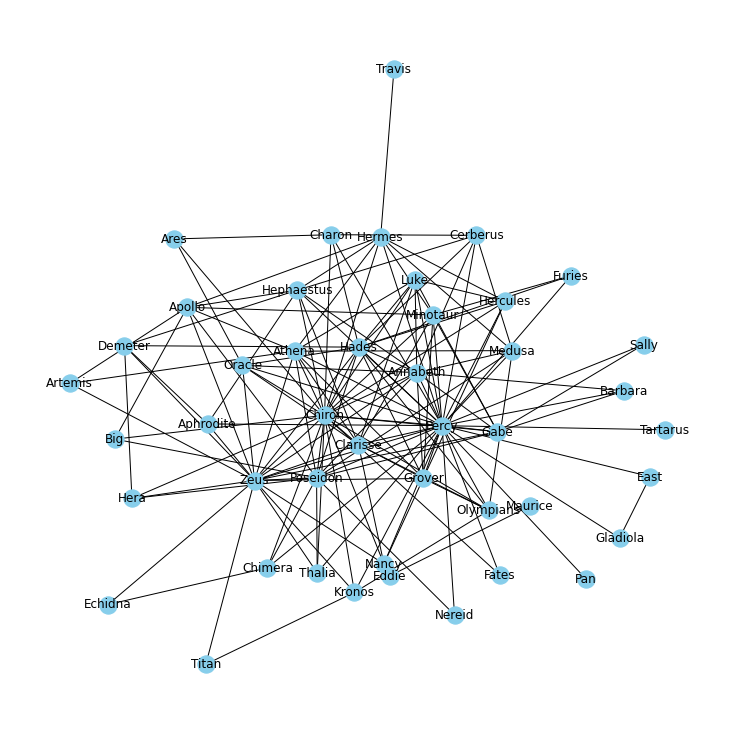

In [28]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G_1)
nx.draw(G_1, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

The above graph shows the relationships between the characters, but is not easy to analyze as it isn't very intuitive. We can use Pyvis to create a better visualization for the graph.

In [29]:
network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
node_degree = dict(G_1.degree)
nx.set_node_attributes(G_1, node_degree, 'size')

network.from_nx(G_1)

network.save_graph('Graphs/relationships.html')
network.show('relationships.html')

From this graph, we can extract information such as the more important characters (as denoted by larger nodes), and the importance of relationships between characters (as denoted by the thickness, or weight of the edge).

We can further visualize the importance of the characters over the course of the book by using centrality measures. The measures we shall visualize shall be:
* __Degree Centrality__: The measure of the number of incoming and outgoing edges to a node. Higher the degree centrality, the more relationships the node has with other nodes.
* __Betweenness Centrality__: The measure of the amount of influence a node has over the flow of information in a graph. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.
* __Closeness Centrality__: The measure of average inverse distance to all other nodes. Higher closeness centrality implies the node has a shorter distance from other nodes.

In [30]:
#degree centrality
degree_dict = nx.degree_centrality(G_1)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_dict = dict(sorted(degree_dict.items(), key = lambda item : item[1], reverse=True))
degree_dict_10 = dict(list(degree_dict.items())[0:10])


#betweenness centrality
between_dict = nx.betweenness_centrality(G_1)
between_df = pd.DataFrame.from_dict(between_dict, orient='index', columns=['centrality'])
between_dict = dict(sorted(between_dict.items(), key = lambda item : item[1], reverse=True))
between_dict_10 = dict(list(between_dict.items())[0:10])

#closeness centrality
closeness_dict = nx.closeness_centrality(G_1)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_dict = dict(sorted(closeness_dict.items(), key = lambda item : item[1], reverse=True))
closeness_dict_10 = dict(list(closeness_dict.items())[0:10])

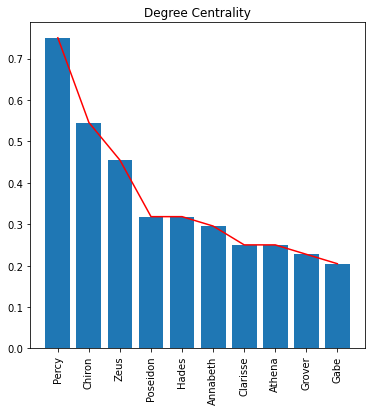

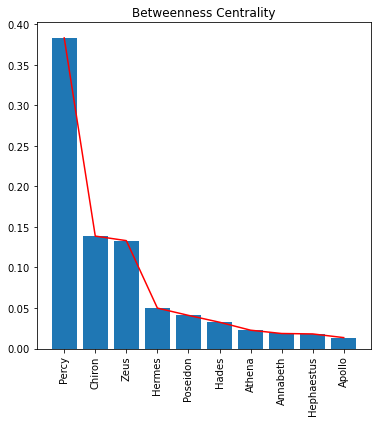

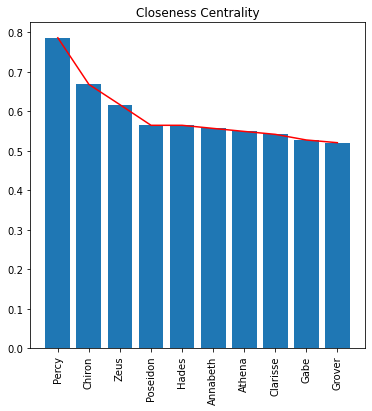

In [31]:
#plotting the top 10 nodes for each centrality

plt.figure(figsize=(6,6))
X_degree = degree_dict_10.keys()
Y_degree = degree_dict_10.values()
plt.plot(X_degree, Y_degree, 'r')
plt.bar(X_degree, Y_degree)
plt.tick_params(axis='x', labelrotation=90)
plt.title('Degree Centrality')
plt.show()


plt.figure(figsize=(6,6))
X_between = between_dict_10.keys()
Y_between = between_dict_10.values()
plt.plot(X_between, Y_between, 'r')
plt.bar(X_between, Y_between)
plt.tick_params(axis='x', labelrotation=90)
plt.title('Betweenness Centrality')
plt.show()


plt.figure(figsize=(6,6))
X_closeness = closeness_dict_10.keys()
Y_closeness = closeness_dict_10.values()
plt.plot(X_closeness, Y_closeness, 'r')
plt.bar(X_closeness, Y_closeness)
plt.tick_params(axis='x', labelrotation=90)
plt.title('Closeness Centrality')
plt.show()

Here we can see that the main characters of the book are relatively the same across the three measures. Some insights that we can extract from these graphs:

* The importance of the main 10 characters decreases steadily.
* The character with the highest betweenness centrality is Percy, implying that he is the character through which the most information is passed through to the other characters. Even the second highest character Chiron has a significantly lower betweeness centrality in comparision.
* The main 10 characters by closeness centrality all have high measures, indicating that the information amongst each of them travels fast, and from the graph visualized above, we can say that their induvidual networks are highly dense.

From these insights, we can understand that there will be certain communities within the entire graph of the characters. Let us try to visualize how these communities interact with each other.

## Community Detection

In [32]:
communities = community_louvain.best_partition(G_1, random_state=99)
communities

{'Titan': 1,
 'Zeus': 1,
 'Nancy': 4,
 'Grover': 4,
 'Percy': 0,
 'Charon': 4,
 'Chiron': 4,
 'Gabe': 0,
 'Sally': 0,
 'Minotaur': 4,
 'Annabeth': 3,
 'Olympians': 4,
 'Hera': 1,
 'Hercules': 4,
 'Hermes': 3,
 'Clarisse': 4,
 'Oracle': 4,
 'Luke': 4,
 'Athena': 1,
 'Poseidon': 1,
 'Ares': 4,
 'Apollo': 1,
 'Hephaestus': 3,
 'Hades': 4,
 'Thalia': 1,
 'Demeter': 1,
 'Aphrodite': 1,
 'Big': 1,
 'Kronos': 1,
 'Fates': 0,
 'Medusa': 3,
 'Pan': 0,
 'Gladiola': 0,
 'East': 0,
 'Chimera': 1,
 'Echidna': 1,
 'Artemis': 1,
 'Eddie': 2,
 'Maurice': 2,
 'Furies': 4,
 'Nereid': 0,
 'Barbara': 0,
 'Cerberus': 3,
 'Tartarus': 0,
 'Travis': 3}

In [33]:
nx.set_node_attributes(G_1, communities, 'group')

In [34]:
community_network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
community_network.from_nx(G_1)
community_network.save_graph('Graphs/Community_relationships_1.html')

community_network.show('Graphs/Community_relationships_1.html')

With this visualization, we can easily "cluster" the characters in the book and see which characters have a community of their own and how these communities interact with each other. From the above visualization we can see that there are a few main communities, specifically Red, Blue, Green and Yellow. 

Red being Percy's community makes sense as he is the protagonist of the book and definitely would have the highest relationships with other smaller characters.

Blue being a community comprising of characters like Zeus and Poseidon also makes sense as these are all the "Olympian Gods". The members of this community interact with each other more often than interacting with the other characters of the book. 

Green being the community of Annabeth also is viable as she is arguably the second main protagonist of the book, helping Percy in his adventures. Thus she has her own connections, seperate from those of Percy's

Finally, Yellow seems to be the comumnity of the other characters in Percy's camp. These seem to be the people that have a lower interaction with Percy over the course of the book, and tend to be mentioned quite less. 

## Books 2-5

Now, lets create similar graphs for the remaining four books and see if we can find any patterns over all five books.

In [35]:
book_doc_2 = create_book_doc(all_books, 1)
book_doc_3 = create_book_doc(all_books, 2)
book_doc_4 = create_book_doc(all_books, 3)
book_doc_5 = create_book_doc(all_books, 4)

In [36]:
sentence_entity_df_book_2 = create_sentence_entity_df(book_doc_2)
sentence_entity_df_book_3 = create_sentence_entity_df(book_doc_3)
sentence_entity_df_book_4 = create_sentence_entity_df(book_doc_4)
sentence_entity_df_book_5 = create_sentence_entity_df(book_doc_5)

In [37]:
relationships_df_book_2 = create_relationship_df(sentence_entity_df_book_2)
relationships_df_book_3 = create_relationship_df(sentence_entity_df_book_3)
relationships_df_book_4 = create_relationship_df(sentence_entity_df_book_4)
relationships_df_book_5 = create_relationship_df(sentence_entity_df_book_5)

In [38]:
relationships_df_book_2 = create_edgelist(relationships_df_book_2)
relationships_df_book_3 = create_edgelist(relationships_df_book_3)
relationships_df_book_4 = create_edgelist(relationships_df_book_4)
relationships_df_book_5 = create_edgelist(relationships_df_book_5)

#### Graph visualization for Book 2

In [39]:
community_network_book_2, G_2 = create_community_graph(relationships_df_book_2, 2)
books_graphs.append(G_2)

community_network_book_2.show('Graphs/Community_relationships_2.html')

#### Graph visualization for Book 3

In [40]:
community_network_book_3, G_3 = create_community_graph(relationships_df_book_3, 3)
books_graphs.append(G_3)

community_network_book_3.show('Graphs/Community_relationships_3.html')

#### Graph visualization for Book 4

In [41]:
community_network_book_4, G_4 = create_community_graph(relationships_df_book_4, 4)
books_graphs.append(G_4)

community_network_book_4.show('Graphs/Community_relationships_4.html')

#### Graph visualization for Book 5

In [42]:
community_network_book_5, G_5 = create_community_graph(relationships_df_book_5, 5)
books_graphs.append(G_5)

community_network_book_5.show('Graphs/Community_relationships_5.html')

Let us see some trends of the main characters that can be extracted from these graphs.

In [43]:
books_graphs


In [44]:
degs = [nx.degree_centrality(graph) for graph in books_graphs]
degs_df = pd.DataFrame(degs)


degs_df

Titan      Zeus     Nancy    Grover     Percy    Charon    Chiron  \
0  0.045455  0.454545  0.113636  0.227273  0.750000  0.113636  0.545455   
1       NaN  0.189655       NaN  0.086207  0.500000       NaN  0.275862   
2  0.176471  0.392157       NaN  0.137255  0.372549       NaN  0.470588   
3  0.126761  0.140845       NaN  0.042254  0.309859       NaN  0.408451   
4  0.296703  0.263736       NaN  0.054945  0.450549  0.010989  0.318681   

       Gabe     Sally  Minotaur  ...     Elpis   Morrain  Hyperion  \
0  0.204545  0.045455  0.181818  ...       NaN       NaN       NaN   
1       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2  0.039216  0.039216  0.019608  ...       NaN       NaN       NaN   
3       NaN  0.028169  0.014085  ...       NaN       NaN       NaN   
4       NaN  0.010989  0.043956  ...  0.010989  0.010989  0.032967   

   Hyperborean     Larry      Owen     Bobby    Lydian     Party   Hunters  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4     0.032967  0.021978  0.010989  0.010989  0.010989  0.021978  0.021978  

[5 rows x 147 columns]

<AxesSubplot:>

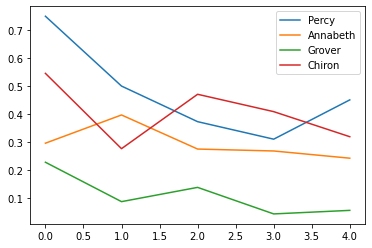

In [45]:
degs_df[['Percy', 'Annabeth', 'Grover', 'Chiron']].plot()

Some interesting trends to point out here:
* As expected, Percy had the highest degree centrality at the start and end of the 5 books. However in book 3 and 4, Chiron seems to have overtaken in degree centrality. This indicates that Chiron's character had more interactions with characters in those books compared to Percy.
* Annabeth's degree centrality seems to be relatively constant throughout the 5 books, only peaking in book 2. Thus a strong assumption could be that her character had more interactions in book 2 compared to the remaining.
* One would assume that Grover, who is supposed to be Percy's sidekick, would have a higher degree centrality, but from the above graph it is evident that he doesn't have much of a role in the series. 

In conclusion, we can see how the community graph visualizations can show us interesting patterns and bring up key points to check for to further showcase trends in the characters of the 5 book series. This notebook serves to show how such visualizations can be useful.